# Fish price prediction for Fishku company-based capstone project
This notebook is the development code for fish price prediction by **Torani Team (C23-OS02)**

In [ ]:
# Import Dependencies
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
scaler=MinMaxScaler()

In [ ]:
# Import Data
from google.colab import auth
auth.authenticate_user()
import gspread
from google.auth import default
creds, _ = default()
pd.set_option('display.max_columns', None)

gc = gspread.authorize(creds)

# Import data tongkol abu
wb_tongkol_abu= gc.open_by_key('1wfDYsxeOTqnroxiecTK-z-ThcBXTEnMz40bbiLtnB18').sheet1
rows_tongkol_abu = wb_tongkol_abu.get_all_values()
df_tongkol_abu = pd.DataFrame.from_records(rows_tongkol_abu)
df_tongkol_abu.columns = pd.RangeIndex(df_tongkol_abu.columns.size)
df_tongkol_abu = df_tongkol_abu.set_axis(df_tongkol_abu.iloc[0], axis=1).drop(0)
df_tongkol_abu['harga']=df_tongkol_abu['harga'].astype(float)

# Import data bandeng
wb_bandeng= gc.open_by_key('1tpLuinPbruMW2ijC_bWXuiLOJ0oIGtwhYdMwv2acyYE').sheet1
rows_bandeng = wb_bandeng.get_all_values()
df_bandeng = pd.DataFrame.from_records(rows_bandeng)
df_bandeng.columns = pd.RangeIndex(df_bandeng.columns.size)
df_bandeng = df_bandeng.set_axis(df_bandeng.iloc[0], axis=1).drop(0)
df_bandeng['harga']=df_bandeng['harga'].astype(float)

#Import data tongkol komo
wb_komo=gc.open_by_key('1vlZNNJzThNbFoBhNcX_TAaWhYlHT2d-RJc6NrBEuUfo').sheet1
rows_komo = wb_komo.get_all_values()
df_komo = pd.DataFrame.from_records(rows_komo)
df_komo.columns = pd.RangeIndex(df_komo.columns.size)
df_komo = df_komo.set_axis(df_komo.iloc[0], axis=1).drop(0)
df_komo['harga']=df_komo['harga'].astype(float)

#Import data Tenggiri
wb_tenggiri=gc.open_by_key('1pivzi_PZKEz0dpmndybak-WlvaQFiUYnX19K5u2Z06Q').sheet1
rows_tenggiri = wb_tenggiri.get_all_values()
df_tenggiri = pd.DataFrame.from_records(rows_tenggiri)
df_tenggiri.columns = pd.RangeIndex(df_tenggiri.columns.size)
df_tenggiri = df_tenggiri.set_axis(df_tenggiri.iloc[0], axis=1).drop(0)
df_tenggiri['harga']=df_tenggiri['harga'].astype(float)

#Import data kembung lelaki
wb_kembung=gc.open_by_key('1PoN1a_qNmj_WJsfvsevlK-qdAlFN25sXPAyCOdLME2A').sheet1
rows_kembung=wb_kembung.get_all_values()
df_kembung=pd.DataFrame.from_records(rows_kembung)
df_kembung.columns = pd.RangeIndex(df_kembung.columns.size)
df_kembung = df_kembung.set_axis(df_kembung.iloc[0], axis=1).drop(0)
df_kembung['harga']=df_kembung['harga'].astype(float)

# Preparation for neural network

In [ ]:
# Normalize the tongkol abu data
max_tongkol_abu=max(df_tongkol_abu['harga'])
min_tongkol_abu=min(df_tongkol_abu['harga'])
df_tongkol_abu['harga']=scaler.fit_transform(np.array(df_tongkol_abu['harga']).reshape(-1,1))

# Normalize the tongkol komo data
max_komo=max(df_komo['harga'])
min_komo=min(df_komo['harga'])
df_komo['harga']=scaler.fit_transform(np.array(df_komo['harga']).reshape(-1,1))

# Normalize the bandeng data
max_bandeng=max(df_bandeng['harga'])
min_bandeng=min(df_bandeng['harga'])
df_bandeng['harga']=scaler.fit_transform(np.array(df_bandeng['harga']).reshape(-1,1))

# Normalize the tenggiri data
max_tenggiri=max(df_tenggiri['harga'])
min_tenggiri=min(df_tenggiri['harga'])
df_tenggiri['harga']=scaler.fit_transform(np.array(df_tenggiri['harga']).reshape(-1,1))

# Normalize the kembung lelaki data
max_kembung=max(df_kembung['harga'])
min_kembung=min(df_kembung['harga'])
df_kembung['harga']=scaler.fit_transform(np.array(df_kembung['harga']).reshape(-1,1))

In [ ]:
def train_val_split( series, split_time):

    #time_train = time[:time_step]
    series_train = series[:split_time]
    #time_valid = time[time_step:]
    series_valid = series[split_time:]

    return series_train, series_valid


# Split the dataset of each fishes
tongkol_series_train, tongkol_series_valid = train_val_split(series=df_tongkol_abu, split_time=int(0.8*len(df_tongkol_abu)))
bandeng_series_train, bandeng_series_valid = train_val_split(series=df_bandeng, split_time=int(0.8*len(df_bandeng)))
komo_series_train, komo_series_valid = train_val_split(series=df_komo, split_time=int(0.8*len(df_komo)))
tenggiri_series_train, tenggiri_series_valid = train_val_split(series=df_tenggiri, split_time=int(0.8*len(df_tenggiri)))
kembung_series_train, kembung_series_valid = train_val_split(series=df_kembung, split_time=int(0.8*len(df_kembung)))

In [ ]:
# Windowing the data set
# This windowing is designed for the LSTM architecture input
def df_to_X_y(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X, dtype=float), np.array(y, dtype=float)

# Windowing the tongkol dataset
tongkol_train_set,tongkol_train_label = df_to_X_y(tongkol_series_train['harga'],window_size=8)
tongkol_valid_set,tongkol_valid_label = df_to_X_y(tongkol_series_valid['harga'],window_size=8)

# Windowing the bandeng dataset
bandeng_train_set,bandeng_train_label = df_to_X_y(bandeng_series_train['harga'],window_size=8)
bandeng_valid_set,bandeng_valid_label = df_to_X_y(bandeng_series_valid['harga'],window_size=8)

# Windowing the komo dataset
komo_train_set,komo_train_label = df_to_X_y(komo_series_train['harga'],window_size=8)
komo_valid_set,komo_valid_label = df_to_X_y(komo_series_valid['harga'],window_size=8)

# Windowing the tenggiri dataset
tenggiri_train_set,tenggiri_train_label = df_to_X_y(tenggiri_series_train['harga'],window_size=8)
tenggiri_valid_set,tenggiri_valid_label = df_to_X_y(tenggiri_series_valid['harga'],window_size=8)

# Windowing the kembung lelaki dataset
kembung_train_set,kembung_train_label = df_to_X_y(kembung_series_train['harga'],window_size=8)
kembung_valid_set,kembung_valid_label = df_to_X_y(kembung_series_valid['harga'],window_size=8)

# Tongkol Abu LSTM

In [ ]:
# LSTM Model for Tongkol Abu fish
model_tongkolabu = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2, 
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1),
             tf.keras.layers.Lambda(lambda x: x * 34.66)])

# Compile the model passing in the appropriate loss
model_tongkolabu.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_tongkolabu.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, None, 4)           12        
                                                                 
 bidirectional (Bidirectiona  (None, None, 32)         2688      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 8)                 136       
                                                                 
 dense_2 (Dense)             (None, 1)                 9

In [ ]:
# Train the model
history_tongkolabu=model_tongkolabu.fit(tongkol_train_set, tongkol_train_label, validation_data=(tongkol_valid_set,tongkol_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 18s 211ms/step - loss: 0.0477 - mae: 0.2311 - val_loss: 0.0025 - val_mae: 0.0546
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0097 - mae: 0.1033 - val_loss: 0.0036 - val_mae: 0.0668
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0056 - mae: 0.0842 - val_loss: 0.0022 - val_mae: 0.0486
Epoch 4/500
8/8 [==============================] - 0s 17ms/step - loss: 0.0049 - mae: 0.0767 - val_loss: 0.0020 - val_mae: 0.0541
Epoch 5/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0049 - mae: 0.0753 - val_loss: 0.0021 - val_mae: 0.0549
Epoch 6/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0046 - mae: 0.0745 - val_loss: 0.0022 - val_mae: 0.0475
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0045 - mae: 0.0738 - val_loss: 0.0019 - val_mae: 0.0487
Epoch 8/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0043 - mae: 0.

In [ ]:
# Evaluate the model with measured metrics (Loss and MAE)
model_tongkolabu.evaluate(tongkol_valid_set,tongkol_valid_label, batch_size=50)

2/2 [==============================] - 0s 29ms/step - loss: 1.0275e-04 - mae: 0.0104


[0.0001027530524879694, 0.010372936725616455]

2/2 [==============================] - 1s 8ms/step


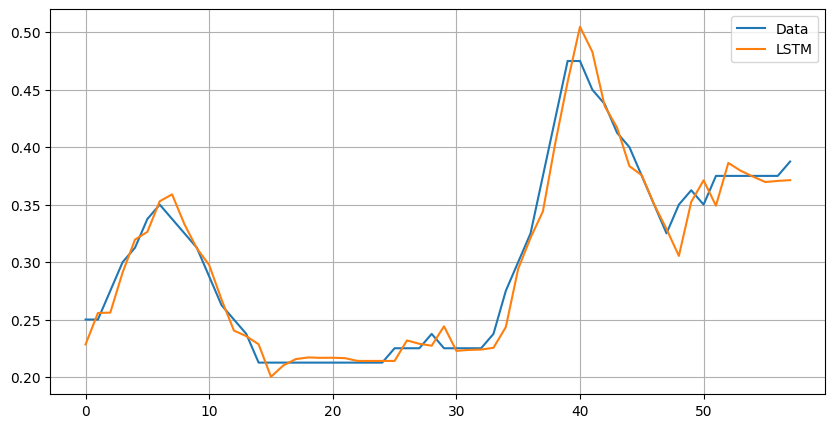

In [ ]:
# Plot the prediction result compared to validation data
predicted_tongkol_abu_LSTM=model_tongkolabu.predict(tongkol_valid_set)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(tongkol_valid_label)),tongkol_valid_label,label='Data')
plt.plot(np.arange(len(predicted_tongkol_abu_LSTM)),predicted_tongkol_abu_LSTM,label='LSTM')
plt.grid()
plt.legend()

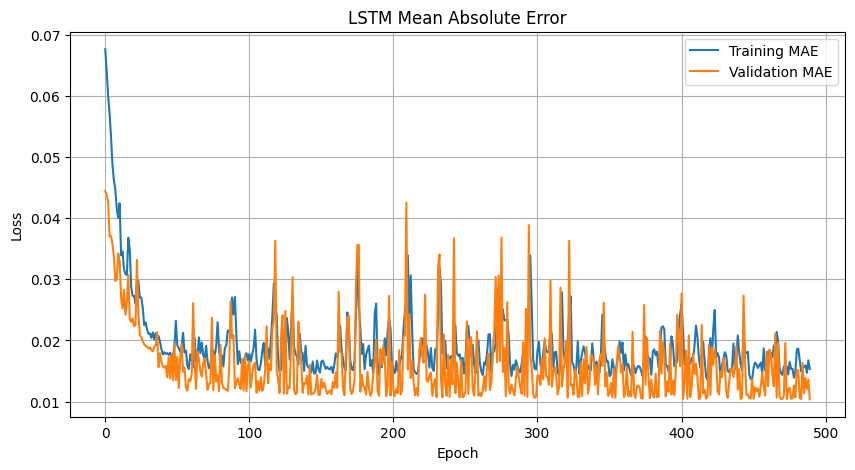

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_tongkolabu.history['mae'][10:],label='Training MAE')
plt.plot(history_tongkolabu.history['val_mae'][10:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

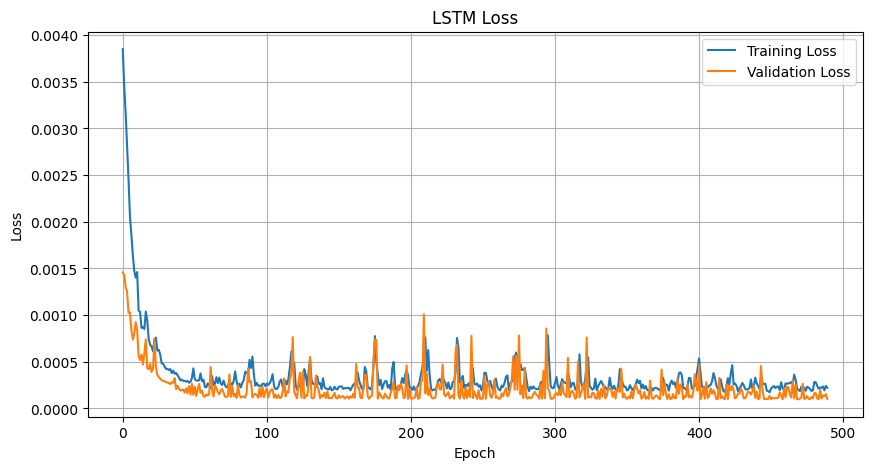

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_tongkolabu.history['loss'][10:],label='Training Loss')
plt.plot(history_tongkolabu.history['val_loss'][10:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
from sklearn.metrics import mean_absolute_error

#Predict the validation data
predicted_tongkol_abu_LSTM=model_tongkolabu.predict(tongkol_valid_set)

#Unnormalize the data
tongkol_series_valid['harga']=(tongkol_series_valid['harga']*(max_tongkol_abu-min_tongkol_abu))+min_tongkol_abu
predicted_tongkol_abu_LSTM=(predicted_tongkol_abu_LSTM*(max_tongkol_abu-min_tongkol_abu))+min_tongkol_abu

#Calculate MAE
mae_lstm=mean_absolute_error(tongkol_valid_label,predicted_tongkol_abu_LSTM)

#Calculate the Mean absolute error in Rupiah
print('LSTM Mean Absolute Error:','Rp',mae_lstm)

2/2 [==============================] - 0s 7ms/step
LSTM Mean Absolute Error: Rp 51.86476293103486


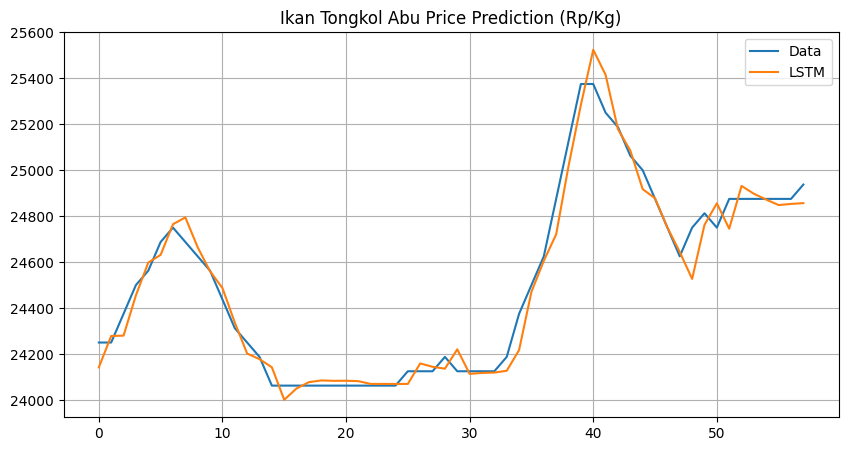

In [ ]:
#Plot the figure in Rupiah/Kg

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(tongkol_series_valid[8:])),tongkol_series_valid['harga'][8:],label='Data')
plt.plot(np.arange(len(predicted_tongkol_abu_LSTM)),predicted_tongkol_abu_LSTM,label='LSTM')
plt.title('Ikan Tongkol Abu Price Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot the figure in plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(tongkol_series_valid)), y=tongkol_valid_label, name='Data'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_tongkol_abu_LSTM)), y=predicted_tongkol_abu_LSTM.flatten(), name='LSTM'))
fig.update_layout(title='Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()


# Tongkol Komo LSTM

In [ ]:
# LSTM Model for Tongkol Komo fish
model_komo = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2, 
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1),
             tf.keras.layers.Lambda(lambda x: x * 34.5)]) 

# Compile the model passing in the appropriate loss
model_komo.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_komo.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, None, 4)           12        
                                                                 
 bidirectional_2 (Bidirectio  (None, None, 32)         2688      
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 8)                 136       
                                                                 
 dense_5 (Dense)             (None, 1)                

In [ ]:
# Train the model
history_komo=model_komo.fit(komo_train_set, komo_train_label, validation_data=(komo_valid_set,komo_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 9s 196ms/step - loss: 0.0133 - mae: 0.1263 - val_loss: 0.0024 - val_mae: 0.0548
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0043 - mae: 0.0761 - val_loss: 0.0018 - val_mae: 0.0507
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0036 - mae: 0.0668 - val_loss: 0.0031 - val_mae: 0.0624
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0027 - mae: 0.0545 - val_loss: 0.0030 - val_mae: 0.0630
Epoch 5/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0021 - mae: 0.0479 - val_loss: 0.0033 - val_mae: 0.0661
Epoch 6/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0022 - mae: 0.0515 - val_loss: 0.0017 - val_mae: 0.0440
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0019 - mae: 0.0453 - val_loss: 0.0013 - val_mae: 0.0422
Epoch 8/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0016 - mae: 0.0

In [ ]:
# Evaluate the Loss and MAE of the model after training
model_komo.evaluate(komo_valid_set,komo_valid_label, batch_size=50)

2/2 [==============================] - 0s 10ms/step - loss: 2.5075e-04 - mae: 0.0180


[0.0002507533354219049, 0.01801854930818081]

2/2 [==============================] - 2s 8ms/step


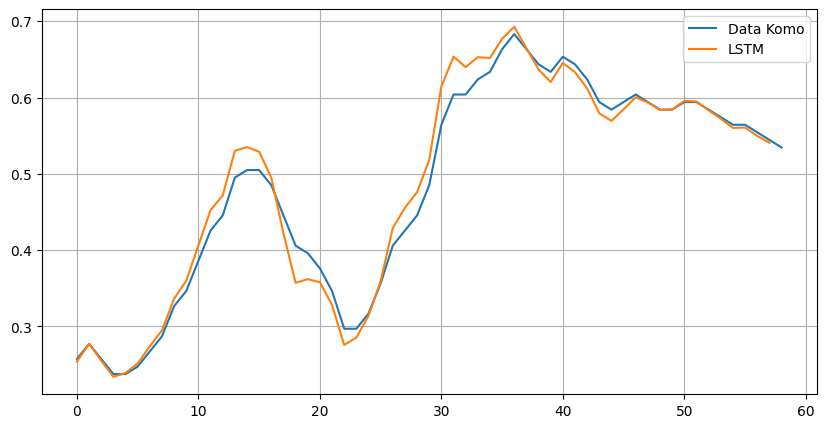

In [ ]:
# Predict and plot the results along with validation data
predicted_komo=model_komo.predict(komo_valid_set)

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(komo_series_valid[7:])),komo_series_valid['harga'][7:],label='Data Komo')
plt.plot(np.arange(len(predicted_komo)),predicted_komo,label='LSTM')
plt.grid()
plt.legend()

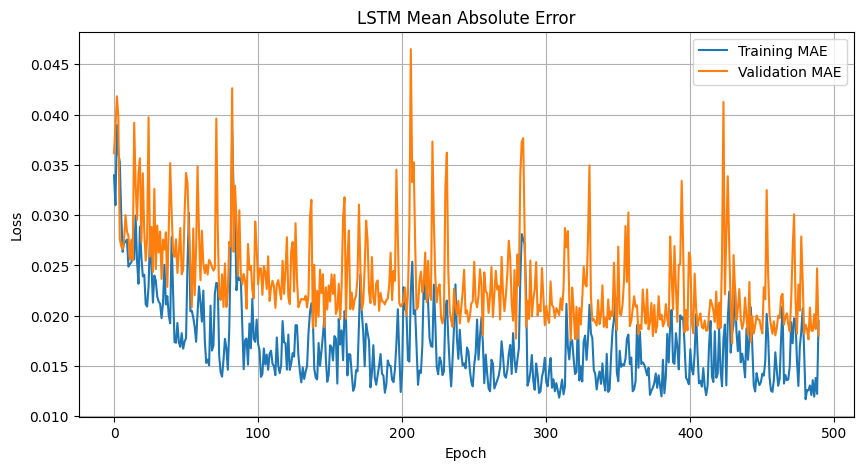

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_komo.history['mae'][10:],label='Training MAE')
plt.plot(history_komo.history['val_mae'][10:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

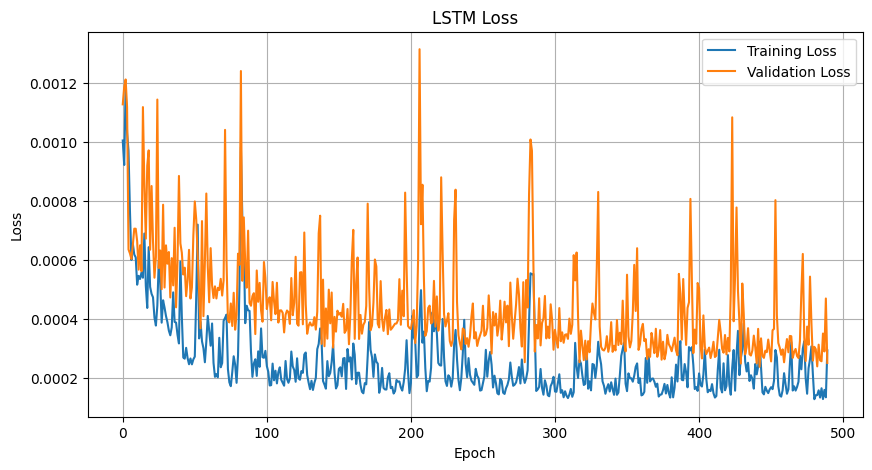

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_komo.history['loss'][10:],label='Training Loss')
plt.plot(history_komo.history['val_loss'][10:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Predict the validation data
predicted_komo=model_komo.predict(komo_valid_set)
np.mean((np.array(komo_series_valid['harga'][8:])/predicted_komo))

2/2 [==============================] - 0s 7ms/step


1.1135161727450265

In [ ]:
from sklearn.metrics import mean_absolute_error

#Scale back the price data
komo_series_valid['harga']=(komo_series_valid['harga']*(max_komo-min_komo))+min_komo
predicted_komo=(predicted_komo*(max_komo-min_komo))+min_komo

#Calculate MAE
mae_komo=mean_absolute_error(komo_series_valid['harga'][8:],predicted_komo)

print('LSTM Mean Absolute Error:','Rp',mae_komo)

LSTM Mean Absolute Error: Rp 113.74205280172414


<ipython-input-23-e154024363d0>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



ValueError: ignored

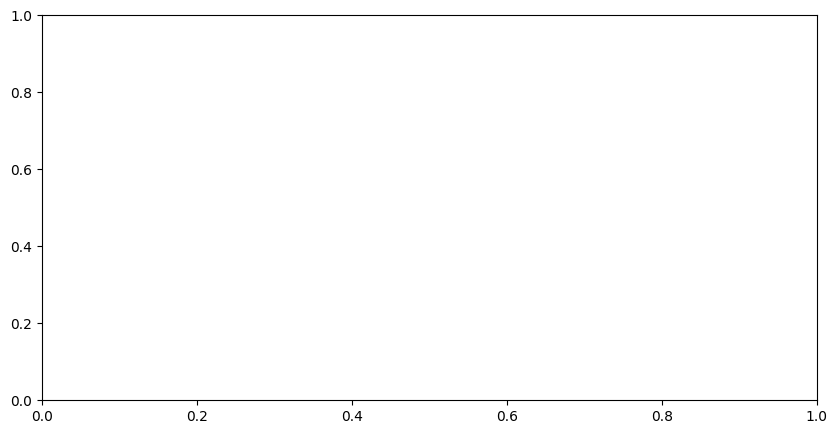

In [ ]:
#Plot the figure in Rp/Kg scale
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(komo_series_valid[8:])),komo_series_valid['harga'][8:],label='Data')
plt.plot(np.arange(len(predicted_komo)),predicted_komo,label='LSTM')
plt.title('Ikan Tongkol Abu Price Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot the prediction results with Plotly for interacitvity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(komo_series_valid[7:])), y=komo_series_valid['harga'][7:], name='Data'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_komo)), y=predicted_komo.flatten(), name='LSTM'))
fig.update_layout(title='Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()


# Bandeng LSTM

In [ ]:
# LSTM Model for Bandeng fish
model_bandeng = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2,
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1),
             tf.keras.layers.Lambda(lambda x: x * 34.6)])

# Compile the model passing in the appropriate loss
model_bandeng.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_bandeng.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_2 (Conv1D)           (None, None, 4)           12        
                                                                 
 bidirectional_4 (Bidirectio  (None, None, 32)         2688      
 nal)                                                            
                                                                 
 bidirectional_5 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_6 (Dense)             (None, 16)                528       
                                                                 
 dense_7 (Dense)             (None, 8)                 136       
                                                                 
 dense_8 (Dense)             (None, 1)                

In [ ]:
# Train the model
history_bandeng=model_bandeng.fit(bandeng_train_set, bandeng_train_label, validation_data=(bandeng_valid_set,bandeng_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 9s 200ms/step - loss: 0.5180 - mae: 0.8595 - val_loss: 0.0515 - val_mae: 0.2843
Epoch 2/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0340 - mae: 0.2035 - val_loss: 0.0179 - val_mae: 0.1527
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0229 - mae: 0.1713 - val_loss: 0.0135 - val_mae: 0.1202
Epoch 4/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0238 - mae: 0.1781 - val_loss: 0.0138 - val_mae: 0.1288
Epoch 5/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0237 - mae: 0.1774 - val_loss: 0.0132 - val_mae: 0.1168
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0218 - mae: 0.1680 - val_loss: 0.0132 - val_mae: 0.1090
Epoch 7/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0208 - mae: 0.1618 - val_loss: 0.0135 - val_mae: 0.1157
Epoch 8/500
8/8 [==============================] - 0s 16ms/step - loss: 0.0197 - mae: 0.1

In [ ]:
# Evaluate the Loss and MAE of the model after training
model_bandeng.evaluate(bandeng_valid_set,bandeng_valid_label, batch_size=50)

2/2 [==============================] - 0s 9ms/step - loss: 8.0452e-04 - mae: 0.0315


[0.0008045200956985354, 0.031525157392024994]

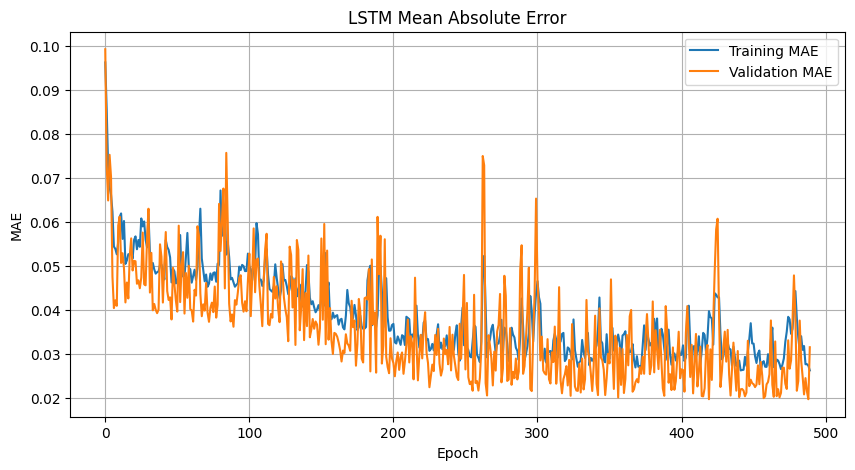

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_bandeng.history['mae'][10:],label='Training MAE')
plt.plot(history_bandeng.history['val_mae'][10:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

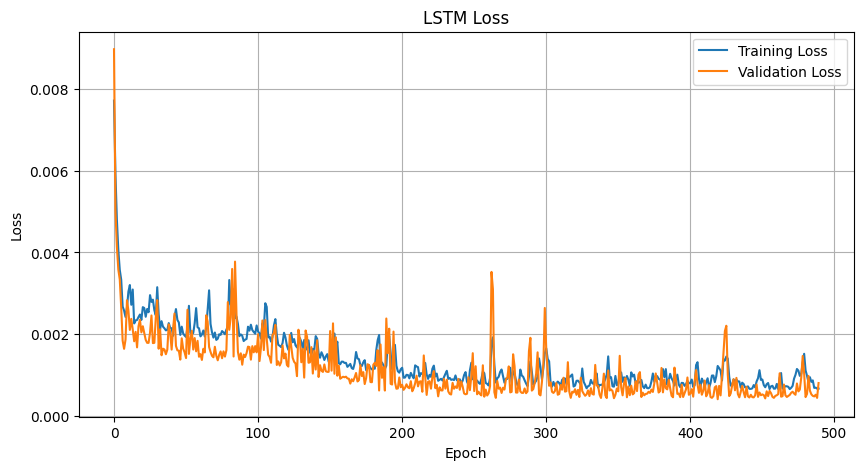

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_bandeng.history['loss'][10:],label='Training Loss')
plt.plot(history_bandeng.history['val_loss'][10:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Predict the validation data
predicted_bandeng=model_bandeng.predict(bandeng_valid_set)

2/2 [==============================] - 2s 9ms/step


1.0351756972981665

In [ ]:
from sklearn.metrics import mean_absolute_error

#Scale back the price data
bandeng_series_valid['harga']=(bandeng_series_valid['harga']*(max_bandeng-min_bandeng))+min_bandeng
predicted_bandeng=(predicted_bandeng*(max_bandeng-min_bandeng))+min_bandeng

#Calculate MAE
mae_bandeng=mean_absolute_error(bandeng_series_valid['harga'][:-8],predicted_bandeng)

print('LSTM Mean Absolute Error:','Rp',mae_bandeng)

LSTM Mean Absolute Error: Rp 546.1236866918103


<ipython-input-31-a4062d4c5b4a>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



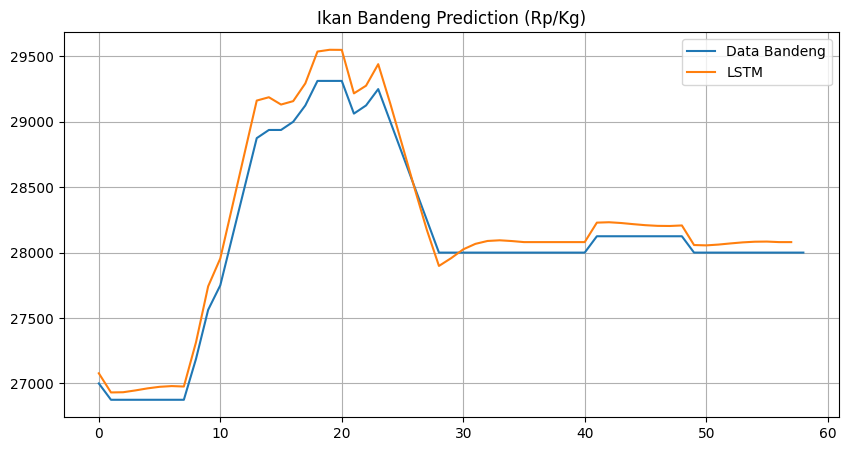

In [ ]:
#Plot the figure in Rp/Kg

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(bandeng_series_valid[7:])),bandeng_series_valid['harga'][7:],label='Data Bandeng')
plt.plot(np.arange(len(predicted_bandeng)),predicted_bandeng,label='LSTM')
plt.title('Ikan Bandeng Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot using Plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(bandeng_series_valid[7:])), y=bandeng_series_valid['harga'][7:], name='Data Bandeng'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_bandeng)), y=predicted_bandeng.flatten(), name='LSTM'))
fig.update_layout(title='Ikan Bandeng: Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()


# Kembung LSTM

In [ ]:
# LSTM Model for Kembung Lelaki fish
model_kembung = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2,
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1),
             tf.keras.layers.Lambda(lambda x: x * 0.07)])

# Compile the model passing in the appropriate loss
model_kembung.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_kembung.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_3 (Conv1D)           (None, None, 4)           12        
                                                                 
 bidirectional_6 (Bidirectio  (None, None, 32)         2688      
 nal)                                                            
                                                                 
 bidirectional_7 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 8)                 136       
                                                                 
 dense_11 (Dense)            (None, 1)                

In [ ]:
# Train the model
history_kembung=model_kembung.fit(kembung_train_set, kembung_train_label, validation_data=(kembung_valid_set,kembung_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 10s 205ms/step - loss: 0.1699 - mae: 0.5586 - val_loss: 0.0164 - val_mae: 0.1645
Epoch 2/500
8/8 [==============================] - 0s 19ms/step - loss: 0.1682 - mae: 0.5557 - val_loss: 0.0159 - val_mae: 0.1620
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.1658 - mae: 0.5515 - val_loss: 0.0153 - val_mae: 0.1582
Epoch 4/500
8/8 [==============================] - 0s 14ms/step - loss: 0.1618 - mae: 0.5444 - val_loss: 0.0142 - val_mae: 0.1513
Epoch 5/500
8/8 [==============================] - 0s 14ms/step - loss: 0.1536 - mae: 0.5294 - val_loss: 0.0117 - val_mae: 0.1360
Epoch 6/500
8/8 [==============================] - 0s 15ms/step - loss: 0.1369 - mae: 0.4981 - val_loss: 0.0075 - val_mae: 0.1072
Epoch 7/500
8/8 [==============================] - 0s 14ms/step - loss: 0.1115 - mae: 0.4442 - val_loss: 0.0032 - val_mae: 0.0703
Epoch 8/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0801 - mae: 0.

In [ ]:
# Evaluate the Loss and MAE of the model after training
model_kembung.evaluate(kembung_valid_set,kembung_valid_label, batch_size=50)

2/2 [==============================] - 0s 10ms/step - loss: 0.0029 - mae: 0.0627


[0.002910617273300886, 0.06273964047431946]

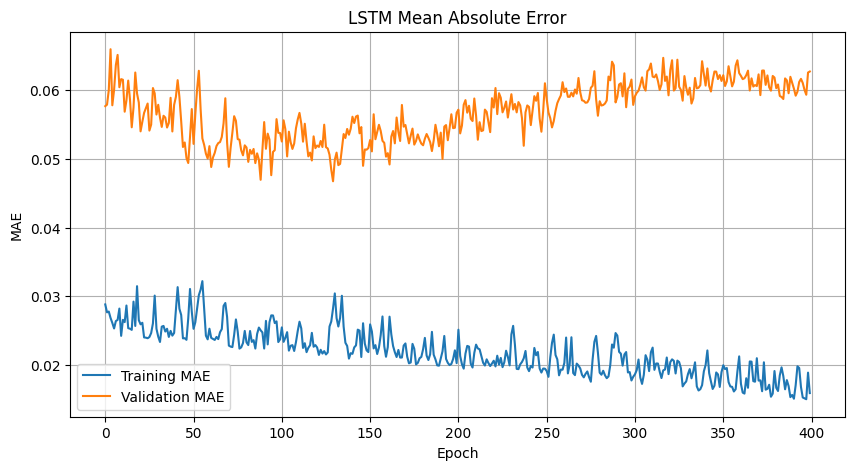

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_kembung.history['mae'][100:],label='Training MAE')
plt.plot(history_kembung.history['val_mae'][100:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

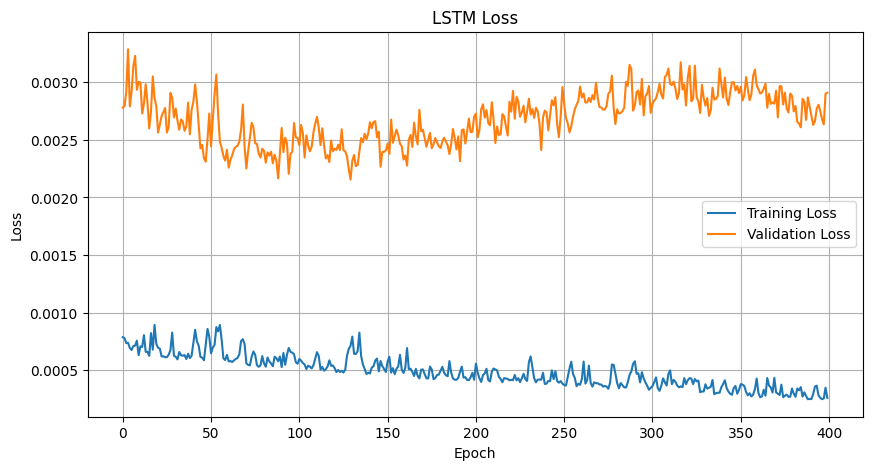

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_kembung.history['loss'][100:],label='Training Loss')
plt.plot(history_kembung.history['val_loss'][100:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Predict the validation data
predicted_kembung=model_kembung.predict(kembung_valid_set)
kembung_series_valid['harga']=(kembung_series_valid['harga']*(max_kembung-min_kembung))+min_kembung
np.mean((np.array(kembung_series_valid['harga'][:-8])/predicted_kembung))

2/2 [==============================] - 1s 8ms/step


<ipython-input-39-ae7223d85d23>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



277271.46567296225

In [ ]:
from sklearn.metrics import mean_absolute_error

#Scale back the price data
predicted_kembung=(predicted_kembung*(max_kembung-min_kembung))+min_kembung

#Calculate MAE
mae_kembung=mean_absolute_error(kembung_series_valid['harga'][:-8],predicted_kembung)

print('LSTM Mean Absolute Error:','Rp',mae_kembung)

LSTM Mean Absolute Error: Rp 648.2417497306031


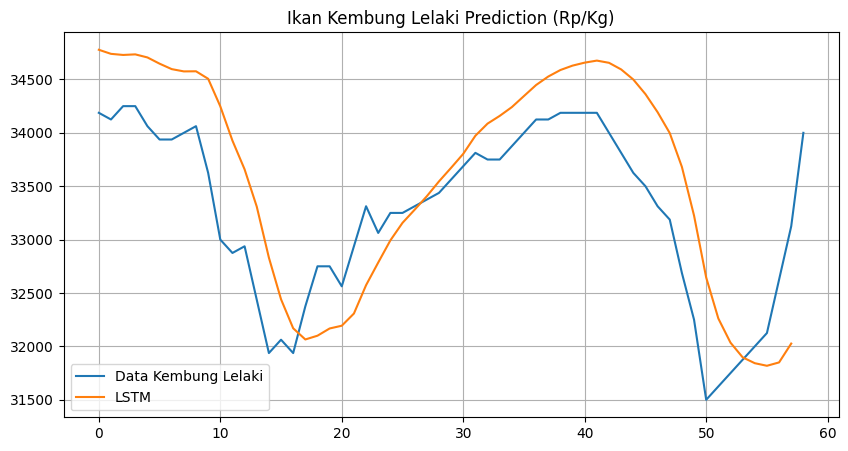

In [ ]:
#Plot the figure

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(kembung_series_valid[7:])),kembung_series_valid['harga'][7:],label='Data Kembung Lelaki')
plt.plot(np.arange(len(predicted_kembung)),predicted_kembung,label='LSTM')
plt.title('Ikan Kembung Lelaki Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot using Plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(kembung_series_valid[7:])), y=kembung_series_valid['harga'][7:], name='Data Kembung Lelaki'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_kembung)), y=predicted_kembung.flatten(), name='LSTM'))
fig.update_layout(title='Ikan Kembung Lelaki: Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()


# Tenggiri LSTM

In [ ]:
# LSTM Model for Tenggiri fish
model_tenggiri = tf.keras.models.Sequential([ 
             tf.keras.layers.Conv1D(filters=4, kernel_size=2, 
                              strides=1, padding="causal",
                              activation="relu",
                              input_shape=[None, 1]),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16, return_sequences=True)),
             tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
             tf.keras.layers.Dense(16, activation="relu"),
             tf.keras.layers.Dense(8, activation="relu"),
             tf.keras.layers.Dense(1)])

# Compile the model passing in the appropriate loss
model_tenggiri.compile(loss=tf.keras.losses.Huber(),
              optimizer='adam', 
              metrics=["mae"])

model_tenggiri.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, None, 4)           12        
                                                                 
 bidirectional_8 (Bidirectio  (None, None, 32)         2688      
 nal)                                                            
                                                                 
 bidirectional_9 (Bidirectio  (None, 32)               6272      
 nal)                                                            
                                                                 
 dense_12 (Dense)            (None, 16)                528       
                                                                 
 dense_13 (Dense)            (None, 8)                 136       
                                                                 
 dense_14 (Dense)            (None, 1)                

In [ ]:
# Train the model
history_tenggiri=model_tenggiri.fit(tenggiri_train_set, tenggiri_train_label, validation_data=(tenggiri_valid_set,tenggiri_valid_label), epochs=500)

Epoch 1/500
8/8 [==============================] - 10s 198ms/step - loss: 0.1264 - mae: 0.4551 - val_loss: 0.0346 - val_mae: 0.2277
Epoch 2/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0715 - mae: 0.3287 - val_loss: 0.0129 - val_mae: 0.1343
Epoch 3/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0273 - mae: 0.1826 - val_loss: 0.0121 - val_mae: 0.1247
Epoch 4/500
8/8 [==============================] - 0s 13ms/step - loss: 0.0151 - mae: 0.1484 - val_loss: 0.0279 - val_mae: 0.2049
Epoch 5/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0153 - mae: 0.1472 - val_loss: 0.0146 - val_mae: 0.1362
Epoch 6/500
8/8 [==============================] - 0s 14ms/step - loss: 0.0132 - mae: 0.1323 - val_loss: 0.0100 - val_mae: 0.1160
Epoch 7/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0128 - mae: 0.1287 - val_loss: 0.0120 - val_mae: 0.1244
Epoch 8/500
8/8 [==============================] - 0s 15ms/step - loss: 0.0118 - mae: 0.

In [ ]:
# Evaluate the Loss and MAE of the model after training
model_tenggiri.evaluate(tenggiri_valid_set,tenggiri_valid_label, batch_size=50)

2/2 [==============================] - 0s 13ms/step - loss: 0.0012 - mae: 0.0362


[0.0012438703561201692, 0.03615954890847206]

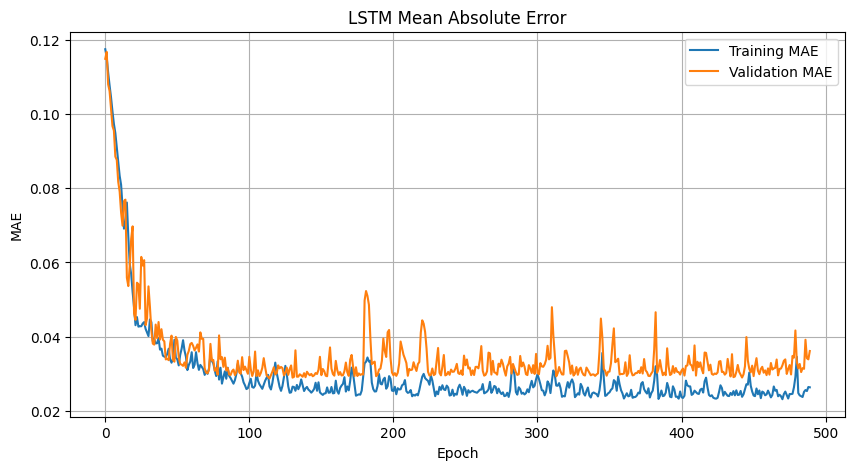

In [ ]:
# Plot the result MAE
plt.figure(figsize=(10, 5))
plt.plot(history_tenggiri.history['mae'][10:],label='Training MAE')
plt.plot(history_tenggiri.history['val_mae'][10:],label='Validation MAE')
plt.title('LSTM Mean Absolute Error')
plt.ylabel('MAE')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

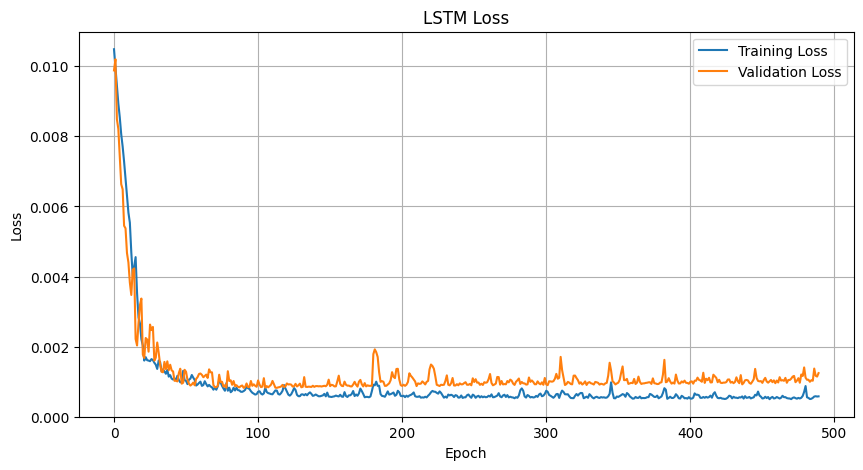

In [ ]:
# Plot the loss of LSTM model
plt.figure(figsize=(10, 5))
plt.plot(history_tenggiri.history['loss'][10:],label='Training Loss')
plt.plot(history_tenggiri.history['val_loss'][10:],label='Validation Loss')
plt.title('LSTM Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#Predict the validation data
predicted_tenggiri=model_tenggiri.predict(tenggiri_valid_set)
np.mean((np.array(tenggiri_series_valid['harga'][:-8])/predicted_tenggiri))

2/2 [==============================] - 2s 10ms/step


1.215145651735964

In [ ]:
from sklearn.metrics import mean_absolute_error

#Scale back the price data
tenggiri_series_valid['harga']=(tenggiri_series_valid['harga']*(max_tenggiri-min_tenggiri))+min_tenggiri
predicted_tenggiri=(predicted_tenggiri*(max_tenggiri-min_tenggiri))+min_tenggiri

#Calculate MAE
mae_tenggiri=mean_absolute_error(tenggiri_series_valid['harga'][:-8],predicted_tenggiri)

print('LSTM Mean Absolute Error:','Rp',mae_tenggiri)

LSTM Mean Absolute Error: Rp 1302.6573949353449


<ipython-input-49-af856f9acbdc>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



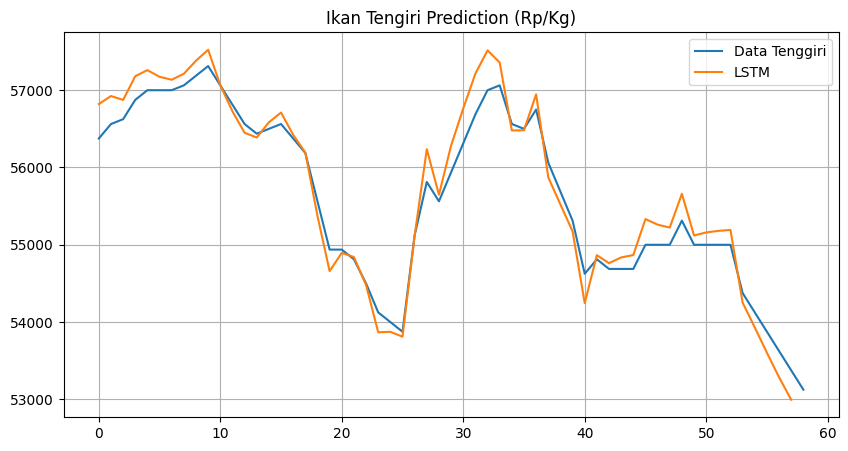

In [ ]:
#Plot the figure in Rp/Kg

plt.figure(figsize=(10,5))
plt.plot(np.arange(len(tenggiri_series_valid[7:])),tenggiri_series_valid['harga'][7:],label='Data Tenggiri')
plt.plot(np.arange(len(predicted_tenggiri)),predicted_tenggiri,label='LSTM')
plt.title('Ikan Tengiri Prediction (Rp/Kg)')
plt.grid()
plt.legend()

In [ ]:
# Plot the prediction result using Plotly for interactivity
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(x=np.arange(len(tenggiri_series_valid[7:])), y=tenggiri_series_valid['harga'][7:], name='Data Tengiri'))
fig.add_trace(go.Scatter(x=np.arange(len(predicted_tenggiri)), y=predicted_tenggiri.flatten(), name='LSTM'))
fig.update_layout(title='Ikan Tengiri: Validation Data vs Predictions',
                  xaxis_title='Index',
                  yaxis_title='Value')
fig.show()


# Save the model

In [ ]:
# Mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')

# Define the path to save the model in your Google Drive
path_bandeng = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/new prices/bandeng_model_lstm.h5'
path_kembung_lelaki = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/new prices/kembung_lelaki_model_lstm.h5'
path_komo = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/new prices/tongkol_komo_model_lstm.h5'
path_tongkolabu = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/new prices/tongkol_abu_model_lstm.h5'
path_tenggiri = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/new prices/tenggiri_model_lstm.h5'


# Save the model
model_bandeng.save(path_bandeng)
model_kembung.save(path_kembung_lelaki)
model_komo.save(path_komo)
model_tongkolabu.save(path_tongkolabu)
model_tenggiri.save(path_tenggiri)


Mounted at /content/gdrive


# Load the trained model
In case further evaluation needed, this section will load the trained model. So, it is not necessary to retrain the model for further model evaluation

In [ ]:
# Mount Google Drive in Google Colab
from google.colab import drive
drive.mount('/content/gdrive')


# Define the path to save the model in your Google Drive
path_bandeng = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/TF/new prices/bandeng_model_lstm.h5'
path_kembung_lelaki = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/TF/new prices/kembung_lelaki_model_lstm.h5'
path_komo = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/TF/new prices/tongkol_komo_model_lstm.h5'
path_tongkolabu = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/TF/new prices/tongkol_abu_model_lstm.h5'
path_tenggiri = f'/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/models/TF/new prices/tenggiri_model_lstm.h5'

# Load the model using TensorFlow
model_bandeng = tf.keras.models.load_model(path_bandeng)
model_kembung = tf.keras.models.load_model(path_kembung_lelaki)
model_komo = tf.keras.models.load_model(path_komo)
model_tongkolabu = tf.keras.models.load_model(path_tongkolabu)
model_tenggiri = tf.keras.models.load_model(path_tenggiri)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Prediction
To predict the fish prices, a dataframe of the fish prices for the next 7 days will be created. First, the model will predict for the next day then the prediction results for the first day will be used again as an input to predict the price for the second day. And the recurring process will occur until 7 days of fish prices is acquired.

In [ ]:
# Define the example
start_date = pd.to_datetime('2023-02-08') # Example date
n_time = 7 # Predict the data for the next 7 days

def generate_predictions(start_date, n_time, model, input_data,min,max):
    # Create an empty dataframe to store the predictions
    predictions_df = pd.DataFrame(columns=['Date', 'Price'])
    
    # Reshape the input_data to maintain the original shape for future predictions
    input_data = input_data.to_numpy().reshape(1, -1, 1)
    
    # Generate predictions for each day ahead
    for i in range(n_time):
        # Prepare the input data for prediction
        input_data_pred = input_data[:, -8:, :]  # Use the last 8 values for prediction
        
        # Predict the next price using the model
        predicted_price = model.predict(input_data_pred)
        # Add the prediction to the dataframe
        prediction_row = {'Date': start_date + pd.DateOffset(days=i), 'Price': ((predicted_price*(max-min))+min)[0][0]}
        predictions_df = predictions_df.append(prediction_row, ignore_index=True)
        
        # Update the input data for the next prediction
        input_data = np.concatenate((input_data, predicted_price.reshape(1, 1, 1)), axis=1)

    return predictions_df


In [ ]:
#Predict the fish price

database_tongkol_abu = generate_predictions(start_date=start_date, n_time=n_time, model=model_tongkolabu, input_data=tongkol_series_train['harga'].tail(8),min=min_tongkol_abu,max=max_tongkol_abu)
database_komo = generate_predictions(start_date=start_date, n_time=n_time, model=model_komo, input_data=komo_series_train['harga'].tail(8),min=min_komo,max=max_komo)
database_kembung = generate_predictions(start_date=start_date, n_time=n_time, model=model_kembung, input_data=kembung_series_train['harga'].tail(8),min=min_kembung,max=max_kembung)
database_tenggiri = generate_predictions(start_date=start_date, n_time=n_time, model=model_tenggiri, input_data=tenggiri_series_train['harga'].tail(8),min=min_tenggiri,max=max_tenggiri)
database_bandeng = generate_predictions(start_date=start_date, n_time=n_time, model=model_bandeng, input_data=bandeng_series_train['harga'].tail(8),min=min_bandeng,max=max_bandeng)

1/1 [==============================] - 0s 20ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 20ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 19ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 34ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 30ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)
<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


1/1 [==============================] - 0s 21ms/step


<ipython-input-8-0ca7abb6efe8>:21: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  predictions_df = predictions_df.append(prediction_row, ignore_index=True)


In [ ]:
# Add the fish types in the 'Fish' column
database_tongkol_abu['Fish']='Tongkol Abu'
database_komo['Fish']='Tongkol Komo'
database_kembung['Fish']='Kembung Lelaki'
database_tenggiri['Fish']='Tenggiri'
database_bandeng['Fish']='Bandeng'

In [ ]:
# Combine the database into single dataframe
databases=[database_tongkol_abu,database_komo,database_kembung,database_tenggiri,database_bandeng]
database_all_fish = pd.concat(databases, ignore_index=True)
# Save the concatenated dataframe as a CSV file
database_all_fish.to_csv('/content/gdrive/MyDrive/C23-OS02 Capstone Project Drive/ML/results/database_all_fish.csv', index=False)